# TimeGenerator specialized

How to use time series generator and write a custome time series generator

In [17]:
try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

import os, datetime
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from IPython import display
from IPython.core.display import HTML
from keras.preprocessing.sequence import TimeseriesGenerator
import IPython
from IPython.display import display

mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)


In [18]:
data =
'''
[10 20 30]
[11 21 31]
[12 22 32]
[13 23 33]
'''

0
[10 20 30]
[11 21 31]  ==> [10 20 30]
                [11 21 31]



1
[11 21 31]
[12 22 32] ==>  [11 21 31]
                [12 22 32]

2
[12 22 32]
[13 23 33] ==> 
                [12 22 32]
                [13 23 33]




class TimeSeriesGeneratorSAda:
    def __init__(data, labels):
        self.data = data
        self.labels = labels

    def __init__(data, labelsGenerator):
        self.data = data
        self.labels = labels
        
    def __next__(i):
        d = 'you will contruct'
        return d, self.labelsGenerator[i]
    
    
t = TimeSeriesGeneratorSAda(data, labels)

for i in t:
    print(i) 
        
        

SyntaxError: invalid syntax (<ipython-input-18-0919111bea48>, line 1)

In [15]:
# Read Data
#del dfn1
#Down the data set from: https://www.kaggle.com/stytch16/jena-climate-2009-2016
        
if ( "dfn1" not in globals()):
    csv_path = 'jena_climate_2009_2016.csv.zip'
    df = pd.read_csv(csv_path, nrows=10000)
    df['Date Time'] = pd.to_datetime( df['Date Time'] )

    dfn1= df[['T (degC)']].copy()
    dfn1.index = df['Date Time']

    dfn2= df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']].copy()
    dfn2.index = df['Date Time']

    dfn = dfn2
    dfn
    
h2=dfn2[0:12].to_html()
fi=f"<table border=1><tr><td>{h2}</td></tr></table> {dfn2.shape[0]} rows x {dfn2.shape[1]} columns"
display(HTML(fi))

,T (degC),p (mbar),rho (g/m**3)
Date Time,,,
2009-01-01 00:10:00,-8.02,996.52,1307.75
2009-01-01 00:20:00,-8.41,996.57,1309.80
2009-01-01 00:30:00,-8.51,996.53,1310.24
2009-01-01 00:40:00,-8.31,996.51,1309.19
2009-01-01 00:50:00,-8.27,996.51,1309.00
2009-01-01 01:00:00,-8.05,996.50,1307.86
2009-01-01 01:10:00,-7.62,996.50,1305.68
2009-01-01 01:20:00,-7.62,996.50,1305.69
2009-01-01 01:30:00,-7.91,996.50,1307.17


# Data

Review the data carefully. It has 10k rows, readings taken for every 10 minutes; it is used to show how to use Time series generator; we chose 3 features (it can be one). These are some complicaed ways to use Time Series Generator.

Our first example will be to use Sime Time Series Generator with some history 

In [19]:
# Sanity Check to make sure everything is aligned
tsParams={ 
    "length":         3,
    "batch_size":     2,
    "stride":         1,
    "sampling_rate" : 1
}
data   = dfn2.values
lables = data[:,0]
g = TimeseriesGenerator(data, lables, **tsParams )

#Lets review the generator output
x, y = g[0]    
print(f'{x.shape}, {y.shape} {y[0]}')
print(f'X: \n{x[0]} ==>{y[0]} (4th entry) <= should match every 3rd')

print(f'{x.shape}, {y.shape} {y[0]}')
print(f'X: \n{x[1]} ==>{y[1]} (4th entry) <= should match every 3rd')

(2, 3, 3), (2,) -8.31
X: 
[[  -8.02  996.52 1307.75]
 [  -8.41  996.57 1309.8 ]
 [  -8.51  996.53 1310.24]] ==>-8.31 (4th entry) <= should match every 3rd
(2, 3, 3), (2,) -8.31
X: 
[[  -8.41  996.57 1309.8 ]
 [  -8.51  996.53 1310.24]
 [  -8.31  996.51 1309.19]] ==>-8.27 (4th entry) <= should match every 3rd


## Multi step prediction

TimeseriesGenerator does not inherently support muti step predictions. One way to do it is to prepare a label data as follows and use TimeseriesGenerator

In [20]:
def makestep(a, start, steps=5):
    o= []
    for i in range(steps):
        a1 = a[start+i:-steps+i+1 or None]
        o.append(a1)
    
    return np.hstack([o]).T

#Example showing how makestep works 
nsteps = 3
data   = dfn2.values
lables = data[:,0]

lables = makestep(lables, 0, nsteps)
lables[0:6]

array([[-8.02, -8.41, -8.51],
       [-8.41, -8.51, -8.31],
       [-8.51, -8.31, -8.27],
       [-8.31, -8.27, -8.05],
       [-8.27, -8.05, -7.62],
       [-8.05, -7.62, -7.62]])

In [7]:
#Suppose we want to do 3 step predictions, then:
#
nsteps = 3
data   = dfn2.values
lables = data[:,0]

lables = makestep(lables, 0, nsteps)
data   = data[:-nsteps+1 or None]

g = TimeseriesGenerator(data, lables, **tsParams )

#Lets review the generator output
x, y = g[0]    
print(f'{x.shape}, {y.shape} {y[0]}')
print(f'X: \n{x[0]} ==>{y[0]} (4th entry) <= should match every 3rd')


(2, 3, 3), (2, 3) [-8.31 -8.27 -8.05]
X: 
[[  -8.02  996.52 1307.75]
 [  -8.41  996.57 1309.8 ]
 [  -8.51  996.53 1310.24]] ==>[-8.31 -8.27 -8.05] (4th entry) <= should match every 3rd


In [23]:
class TargetGen(object):
    def __init__(self, targets, nsteps=1):
        self.targets = targets
        self.nsteps  = nsteps
        
    def __len__(self):
        return len(self.targets[:-self.nsteps+1 or None])

    def getData(self, index):
        t = self.targets[index: index + self.nsteps]
        return t

    def __getitem__( self, key ) :
        if isinstance( key, int ) :
            if key < 0: 
                key += len(self)
            if key < 0 or key >= len( self ) :
                raise (IndexError, f"The index (key) is out of range. {len(slef)}")
            return self.getData(key)
        if isinstance( key, slice ) :
            return [self.targets[ii: ii + self.nsteps] for ii in range(*key.indices(len(self)))]
        else:
            raise (TypeError, "Invalid argument type.")

    def __getitem__( self, key ) :
        return self.getData(key)
            
            
data   = dfn2.values
data   = data[:-nsteps+1 or None]
lables = data[:,0]

lg= TargetGen(data, nsteps=3)
len(lg), lg[3]

'''len(obj)  ==> obj.__len__()
obj[i] ==> obj.__getitem__(i)
obj[9:10] ==> obj.__getitem__(slice(9,10))
'''

'len(obj)  ==> obj.__len__()\nobj[i] ==> obj.__getitem__(i)\nobj[9:10] ==> obj.__getitem__(slice(9,10))\n'

In [26]:
#Suppose we want to do 3 step predictions, then:
#
nsteps = 3
data   = dfn2.values
lables = data[:,0]

data   = data[:-nsteps+1 or None]
lables = data[:,0]

lg= TargetGen(lables, nsteps=3)
g = TimeseriesGenerator(data, lg, **tsParams )

#Lets review the generator output
x, y = g[0]    
print(f'{x.shape}, {y.shape} {y[0]}')
print(f'X: \n{x[0]} ==>{y[0]} (4th entry) <= should match every 3rd')


ValueError: Data and targets have to be of same length. Data length is 9998 while target length is 9996

In [55]:
#Check and use it in LSTM model
import keras
from tensorflow.keras.layers import LSTM
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

def lstmmodel(inps, inshape, units2=None, nsteps=1, opt="adam", loss="mse", bi=False, dropout=None):
    s= inshape
    print(locals())
    print(f"Creating LSTM: inuts= {inps} time-steps: {s[0]}, features: {s[1]} #out: {nsteps}")
    m = keras.models.Sequential()

    if (bi):
        m.add(keras.layers.Bidirectional(
            keras.layers.LSTM(inps, return_sequences= (units2 is not None), input_shape=s) ) )
    else:
        m.add(keras.layers.LSTM(inps, return_sequences= (units2 is not None), input_shape=s) )
    
    if(units2 is not None): #Lets just keep it simple for 2 layers only
        m.add(keras.layers.LSTM(units2, activation='relu'))
    if (dropout is not None):
        m.add( keras.layers.Dropout(dropout) )
    m.add(keras.layers.Dense(nsteps))
    m.compile(optimizer = opt, loss= loss)
    return m

def Plot_(y, h, x=None, title=None,**kwargs):
    plt.plot(y[:,0], marker=".", label = "y")

    if ( len(h.shape) <= 1):
        h = h.reshape((len(h), 1))
    for i in range(h.shape[-1]):
        uy=h[i:,i]
        plt.plot(range(i, len(uy)+i), uy, marker="x",  label = f"$h_{i}$")

    plt.title(title)
    plt.grid(b="on")
    plt.legend()
    return y1, h1;


nsteps  = 4
features= 3

tsParams={ 
    "length":         3,
    "batch_size":     2,
    "stride":         1,
    "sampling_rate" : 1
}

m = lstmmodel(32, (tsParams['length'],features), units2=32, nsteps=nsteps, opt="adam", loss="mse" )

data   = dfn2.values
lables = data[:,0]

data   = data[:-nsteps+1 or None]
lables = data[:,0]

lg= TargetGen(data,lables, nsteps=nsteps)
g = TimeseriesGenerator(data, lg, **tsParams )

m.fit(g, verbose=1, epochs=1, steps_per_epoch=200)

{'inps': 32, 'inshape': (3, 3), 'units2': 32, 'nsteps': 4, 'opt': 'adam', 'loss': 'mse', 'bi': False, 'dropout': None, 's': (3, 3)}
Creating LSTM: inuts= 32 time-steps: 3, features: 3 #out: 4
Epoch 1/1
200/200 [==============================] - 1s 5ms/step - loss: 22.2889


Epoch 1/1
200/200 [==============================] - 0s 2ms/step - loss: 24.2348


(array([[-8.31, -8.27, -8.05, -7.62],
        [-8.27, -8.05, -7.62, -7.62]]),
 array([[-0.5325498 , -0.5041434 , -0.48151752, -0.55307007],
        [-0.5325498 , -0.5041434 , -0.48151746, -0.55307007],
        [-0.53254974, -0.5041434 , -0.48151746, -0.55307007],
        ...,
        [-0.5325493 , -0.5041436 , -0.48151758, -0.55306995],
        [-0.5325493 , -0.5041436 , -0.48151758, -0.55306995],
        [-0.5325493 , -0.5041436 , -0.48151758, -0.55306995]],
       dtype=float32))

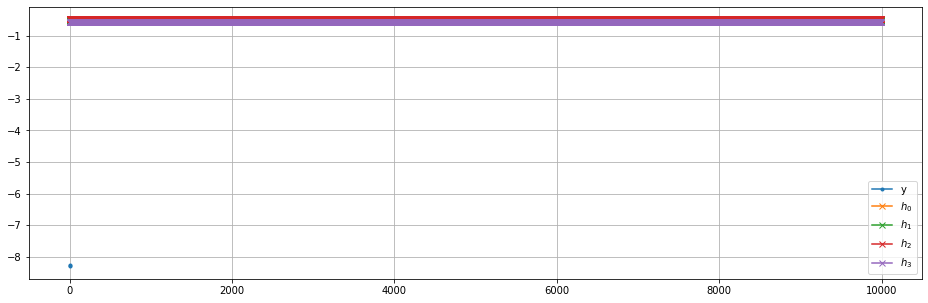

In [57]:
m.fit(g, verbose=1, epochs=1, steps_per_epoch=200)
x, y = g[0]
h = m.predict(g)
h1, y1 = h,y
Plot_(y1,h1)

# Complicated example to include sampling rate

In [ ]:
# Sanity Check to make sure everything is aligned
tsParams={ 
    "length":         720,
    "batch_size":     256,
    "stride":         1,
    "sampling_rate" : 6
}
data   = dfn2.values
labels = data[:,0]
g = TimeseriesGenerator(data, labels, **tsParams )

#Lets review the generator output
x, y = g[0]    
print(f'{x.shape}, {y.shape} {y[0]}')
print(f'X: \n{x[0][-3:]} <= should match every 6th entry\n Also: \n{y[0]} <= 720th entry')

In [ ]:
# Sanity Check to visually check if X and y correctly aligned
# Whenever you see "<=" mark, it is aligned at sampling rate of 6

dfn3= dfn2.copy()
dfn3['idx'] = [i if i % 6 != 0 else f'<={i}' for i in range(len(dfn3))]
display(dfn3[700:724])
del dfn3